use python 3.8.10 due to adafair dependencies


Chat-gpt and Grok were utilized for checking and evaluation of the code 


Preprocessing of the datasets:

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import StratifiedShuffleSplit
from adafair import AdaFair
from sklearn.ensemble import AdaBoostClassifier
from adafair import load_adult
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import scipy.stats as stats

import random
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)

loading/preprocessing of datasets done based on description of https://wires.onlinelibrary.wiley.com/doi/10.1002/widm.1452

In [2]:
def load_communities():
    # Define the column names based on the dataset description
    columns = [
        'state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize',
        'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
        'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage',
        'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc',
        'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap',
        'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad',
        'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ',
        'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv',
        'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
        'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig',
        'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig',
        'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell',
        'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous',
        'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR',
        'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded',
        'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart',
        'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent',
        'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters',
        'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85',
        'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
        'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic',
        'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
        'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
        'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars',
        'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
        'PolicBudgPerPop', 'ViolentCrimesPerPop'
    ]
    
    df = pd.read_csv('/Users/tomcarree/CSAI/thesis/datasets/communities+and+crime/communities.data', header=None, names=columns, na_values='?')
    df = df.rename(columns={'ViolentCrimesPerPop': 'class'}) # rename to obtain class variable
    df['class'] = df['class'].apply(lambda x: 1 if x >= 0.7 else -1) #binarize class column 1, -1 to be able to be accepted by adafair algorithm
    df['racepctblack'] = df['racepctblack'].apply(lambda x: 1 if x >= 0.06 else 0) # binarize protected attribute
    required_columns = [
        'racepctblack', 'pctWInvInc', 'pctWPubAsst', 'NumUnderPov', 'PctPopUnderPov',
        'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam',
        'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'NumIlleg', 'PctIlleg',
        'PctPersOwnOccup', 'HousVacant', 'PctHousOwnOcc', 'PctVacantBoarded',
        'NumInShelters', 'NumStreet', 'class']
    df = df[required_columns] # keep only relevent colums
    df = df.dropna()                # drop rows with missing values
    df = df.drop_duplicates()       # drop duplicates: whole row the same
    return df
   
    

In [3]:
df_communities = load_communities()
print(f"Number of records after processing: {len(df_communities)}")
print("\nColumn names in the processed dataset:")
print(df_communities.columns.tolist())
print("\nprotected attribute distribution:")
print(df_communities['racepctblack'].value_counts()) # 1 being 0.06 or more percentage black population
print("\nclass distribution:")
print(df_communities['class'].value_counts()) # class distribution with  <30 days being 1


Number of records after processing: 1994

Column names in the processed dataset:
['racepctblack', 'pctWInvInc', 'pctWPubAsst', 'NumUnderPov', 'PctPopUnderPov', 'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'NumIlleg', 'PctIlleg', 'PctPersOwnOccup', 'HousVacant', 'PctHousOwnOcc', 'PctVacantBoarded', 'NumInShelters', 'NumStreet', 'class']

protected attribute distribution:
racepctblack
1    1038
0     956
Name: count, dtype: int64

class distribution:
class
-1    1872
 1     122
Name: count, dtype: int64


In [4]:
df_communities.head()

,racepctblack,pctWInvInc,pctWPubAsst,NumUnderPov,PctPopUnderPov,PctUnemployed,MalePctDivorce,FemalePctDiv,TotalPctDiv,PersPerFam,...,PctTeen2Par,NumIlleg,PctIlleg,PctPersOwnOccup,HousVacant,PctHousOwnOcc,PctVacantBoarded,NumInShelters,NumStreet,class
0,0,0.60,0.15,0.08,0.19,0.27,0.68,0.75,0.75,0.35,...,0.56,0.04,0.14,0.55,0.21,0.52,0.05,0.04,0.0,-1
1,1,0.45,0.29,0.01,0.24,0.27,1.00,0.91,1.00,0.29,...,0.39,0.00,0.24,0.26,0.02,0.24,0.02,0.00,0.0,-1
2,1,0.39,0.40,0.01,0.27,0.36,0.63,0.71,0.70,0.45,...,0.43,0.01,0.46,0.42,0.01,0.41,0.29,0.00,0.0,-1
3,1,0.43,0.20,0.01,0.10,0.33,0.34,0.49,0.44,0.75,...,0.65,0.03,0.33,0.94,0.01,0.96,0.60,0.00,0.0,-1
4,0,0.68,0.11,0.00,0.06,0.12,0.22,0.20,0.21,0.51,...,0.85,0.00,0.06,0.89,0.01,0.87,0.04,0.00,0.0,-1


In [5]:
def load_census():
    # define column names
    column_names = [
        'age', 'class_of_worker', 'industry_code', 'occupation_code', 'education',
        'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_status', 'major_industry_code',
        'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_labor_union',
        'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains',
        'capital_losses', 'dividends_from_stocks', 'tax_filer_status', 'region_of_previous_residence',
        'state_of_previous_residence', 'detailed_household_and_family_stat',
        'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa',
        'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
         'migration_previous_res_in_sunbelt','num_persons_worked_for_employer', 'family_members_under_18',
        'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
        'own_business_or_self_employed', 'fill_inc_questionnaire_vet_admin', 'veterans_benefits',
        'weeks_worked_in_year', 'year', 'income_level' ]
    data = pd.read_csv('/Users/tomcarree/CSAI/thesis/datasets/census/census-income.data', header=None, names=column_names, na_values='?', skipinitialspace=True)
    test = pd.read_csv('/Users/tomcarree/CSAI/thesis/datasets/census/census-income.test', header=None, names=column_names, na_values='?', skipinitialspace=True)
    df = pd.concat([data, test], ignore_index=True) # concatenate train and test data as splits will be made differently
    df = df.rename(columns={'income_level': 'class'}) # rename to obtain class variable
    df['sex'] = df['sex'].map({'Male': 0, 'Female': 1}) # binarize protected attribute
    df['class'] = df['class'].map({'- 50000.':-1 , '50000+.':1}) # binarize class variable 1, -1 to be able to be accepted by adafair algorithm
    df = df.dropna()                # drop rows with missing values
    df = df.drop_duplicates()       # drop duplicates: whole row the same
    categorical = [
        'class_of_worker', 'education', 'marital_status', 'major_industry_code',
        'major_occupation_code', 'race', 'hispanic_origin', 'member_of_labor_union',
        'reason_for_unemployment', 'full_or_part_time_employment_stat', 'tax_filer_status',
        'region_of_previous_residence', 'state_of_previous_residence',
        'detailed_household_and_family_stat', 'detailed_household_summary_in_household',
        'migration_code_change_in_msa', 'migration_code_change_in_reg',
        'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
       'family_members_under_18', 'migration_previous_res_in_sunbelt', 'enroll_in_edu_inst_last_wk',
        'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self',
        'citizenship', 'fill_inc_questionnaire_vet_admin', 'veterans_benefits'
    ]
    # numerical encoding categorical features
    for col in categorical:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df




In [6]:
df_census = load_census()
print(f"Number of records after processing: {len(df_census)}")
print("\nColumn names in the processed dataset:")
print(df_census.columns.tolist())
print("\nprotected attribute distribution:")
print(df_census['sex'].value_counts()) # 1 being female
print("\nclass distribution:")
print(df_census['class'].value_counts()) # class, 1 being more than 50k

Number of records after processing: 138335

Column names in the processed dataset:
['age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_status', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_previous_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill

In [7]:
df_census.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_vet_admin,veterans_benefits,weeks_worked_in_year,year,class
1,58,6,4,34,16,0,2,0,4,8,...,37,37,38,4,0,1,2,52,94,-1
3,9,3,0,0,10,0,2,4,14,6,...,37,37,38,4,0,1,0,0,94,-1
4,10,3,0,0,10,0,2,4,14,6,...,37,37,38,4,0,1,0,0,94,-1
6,42,4,34,3,9,0,2,2,7,2,...,37,37,38,4,0,1,2,52,94,-1
9,34,4,4,37,16,0,2,2,4,5,...,37,37,38,4,0,1,2,52,94,-1


In [8]:
# Extract groups for Communities and Crime Dataset
positive_protected_comm = df_communities[(df_communities['racepctblack'] == 1) & (df_communities['class'] == 1)]
negative_protected_comm = df_communities[(df_communities['racepctblack'] == 1) & (df_communities['class'] == -1)]
positive_non_protected_comm = df_communities[(df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)]
negative_non_protected_comm = df_communities[(df_communities['racepctblack'] == 0) & (df_communities['class'] == -1)]

# Extract groups for Census Income Dataset
positive_protected_census = df_census[(df_census['sex'] == 1) & (df_census['class'] == 1)]
negative_protected_census = df_census[(df_census['sex'] == 1) & (df_census['class'] == -1)]
positive_non_protected_census = df_census[(df_census['sex'] == 0) & (df_census['class'] == 1)]
negative_non_protected_census = df_census[(df_census['sex'] == 0) & (df_census['class'] == -1)]

# Print the sizes of each group
print("Communities and Crime Dataset:")
print(f"Positive Protected: {len(positive_protected_comm)}")
print(f"Negative Protected: {len(negative_protected_comm)}")
print(f"Positive Non-Protected: {len(positive_non_protected_comm)}")
print(f"Negative Non-Protected: {len(negative_non_protected_comm)}")

print("\nCensus Income Dataset:")
print(f"Positive Protected: {len(positive_protected_census)}")
print(f"Negative Protected: {len(negative_protected_census)}")
print(f"Positive Non-Protected: {len(positive_non_protected_census)}")
print(f"Negative Non-Protected: {len(negative_non_protected_census)}")

Communities and Crime Dataset:
Positive Protected: 115
Negative Protected: 923
Positive Non-Protected: 7
Negative Non-Protected: 949

Census Income Dataset:
Positive Protected: 1709
Negative Protected: 70416
Positive Non-Protected: 6405
Negative Non-Protected: 59805


create the X, y variable and indicate the protected attribute for each dataset

In [9]:
X_communities = df_communities.drop('class', axis=1).values
y_communities = df_communities['class'].values
saIndex_communities = 0  # 'racepctblack' is the first column
saValue_communities = 1  # Protected group: communities with higher black population

In [10]:
X_census = df_census.drop('class', axis=1).values
y_census = df_census['class'].values
saIndex_census = 12  # 'sex' is at index 12
saValue_census = 1  # Protected group: females

create downsampled datasets for census data: 100x, 10x

In [11]:
# census 100 times downsampled
df_census['strata'] = df_census['class'].astype(str) + '_' + df_census['sex'].astype(str) # create strata attribute to ensure distribution between groups stays the same

# Downsample to exactly 1383 instances
df_census_downsampled, _ = train_test_split(df_census, train_size=1383, stratify=df_census['strata'], random_state=SEED)

# Drop the strata column which ensured group distibutions stayed the same
df_census_downsampled = df_census_downsampled.drop('strata', axis=1)

# Extract groups for Census Income Dataset
positive_protected_census_downsampled = df_census_downsampled[(df_census_downsampled['sex'] == 1) & (df_census_downsampled['class'] == 1)]
negative_protected_census_downsampled = df_census_downsampled[(df_census_downsampled['sex'] == 1) & (df_census_downsampled['class'] == -1)]
positive_non_protected_census_downsampled = df_census_downsampled[(df_census_downsampled['sex'] == 0) & (df_census_downsampled['class'] == 1)]
negative_non_protected_census_downsampled = df_census_downsampled[(df_census_downsampled['sex'] == 0) & (df_census_downsampled['class'] == -1)]

# print the sizes of each group
print("\nCensus Income Dataset downsampled:")
print(f"Total dataset size: {len(df_census_downsampled)}")
print(f"Positive Protected: {len(positive_protected_census_downsampled)}")
print(f"Negative Protected: {len(negative_protected_census_downsampled)}")
print(f"Positive Non-Protected: {len(positive_non_protected_census_downsampled)}")
print(f"Negative Non-Protected: {len(negative_non_protected_census_downsampled)}")

# define X and Y variable for downsampled dataset
X_census_downsampled = df_census_downsampled.drop('class', axis=1).values
y_census_downsampled = df_census_downsampled['class'].values


Census Income Dataset downsampled:
Total dataset size: 1383
Positive Protected: 17
Negative Protected: 704
Positive Non-Protected: 64
Negative Non-Protected: 598


In [12]:
# census 10 times downsampled
df_census['strata'] = df_census['class'].astype(str) + '_' + df_census['sex'].astype(str) # create strata attribute to ensure distribution between groups stays the same

# Downsample to exactly 13833 instances
df_census_downsampled2, _ = train_test_split(df_census, train_size=13833, stratify=df_census['strata'], random_state=SEED)

# Drop the strata column which ensured groupdistibution stayed the same
df_census_downsampled2 = df_census_downsampled2.drop('strata', axis=1)

# Extract groups for Census Income Dataset
positive_protected_census_downsampled2 = df_census_downsampled2[(df_census_downsampled2['sex'] == 1) & (df_census_downsampled2['class'] == 1)]
negative_protected_census_downsampled2 = df_census_downsampled2[(df_census_downsampled2['sex'] == 1) & (df_census_downsampled2['class'] == -1)]
positive_non_protected_census_downsampled2 = df_census_downsampled2[(df_census_downsampled2['sex'] == 0) & (df_census_downsampled2['class'] == 1)]
negative_non_protected_census_downsampled2 = df_census_downsampled2[(df_census_downsampled2['sex'] == 0) & (df_census_downsampled2['class'] == -1)]

# print the sizes of each group
print("\nCensus Income Dataset downsampled:")
print(f"Total dataset size: {len(df_census_downsampled2)}")
print(f"Positive Protected: {len(positive_protected_census_downsampled2)}")
print(f"Negative Protected: {len(negative_protected_census_downsampled2)}")
print(f"Positive Non-Protected: {len(positive_non_protected_census_downsampled2)}")
print(f"Negative Non-Protected: {len(negative_non_protected_census_downsampled2)}")

# define X and Y variable for downsampled dataset
X_census_downsampled2 = df_census_downsampled2.drop('class', axis=1).values
y_census_downsampled2 = df_census_downsampled2['class'].values


Census Income Dataset downsampled:
Total dataset size: 13833
Positive Protected: 171
Negative Protected: 7041
Positive Non-Protected: 641
Negative Non-Protected: 5980


the code below for calculating the performance was reused from the repository of the adafair paper: https://github.com/iosifidisvasileios/AdaFair/blob/master/run_example.ipynb 

Moreover the stratifiedshufllesplit code has been adapted from this repository aswell.

In [13]:
def calculate_performance(data, labels, predictions, saIndex, saValue):
    tp_protected = 0.
    tn_protected = 0.
    fp_protected = 0.
    fn_protected = 0.

    tp_non_protected = 0.
    tn_non_protected = 0.
    fp_non_protected = 0.
    fn_non_protected = 0.
    for idx, val in enumerate(data):
        # protected population
        if val[saIndex] == saValue:
            # correctly classified
            if labels[idx] == predictions[idx]:
                if labels[idx] == 1:
                    tp_protected += 1.
                else:
                    tn_protected += 1.
            # misclassified
            else:
                if labels[idx] == 1:
                    fn_protected += 1.
                else:
                    fp_protected += 1.
        else:
            # correctly classified
            if labels[idx] == predictions[idx]:
                if labels[idx] == 1:
                    tp_non_protected += 1.
                else:
                    tn_non_protected += 1.
            # misclassified
            else:
                if labels[idx] == 1:
                    fn_non_protected += 1.
                else:
                    fp_non_protected += 1.

    tpr_protected = tp_protected / (tp_protected + fn_protected)
    tnr_protected = tn_protected / (tn_protected + fp_protected)

    tpr_non_protected = tp_non_protected / (tp_non_protected + fn_non_protected)
    tnr_non_protected = tn_non_protected / (tn_non_protected + fp_non_protected)

    output = dict()
    output["balanced_accuracy"] =( (tp_protected + tp_non_protected)/(tp_protected + tp_non_protected + fn_protected + fn_non_protected) +
                                   (tn_protected + tn_non_protected) / (tn_protected + tn_non_protected + fp_protected + fp_non_protected))*0.5

    output["accuracy"] = accuracy_score(labels, predictions)
    output["fairness"] = abs(tpr_non_protected - tpr_protected) + abs(tnr_non_protected - tnr_protected)
    output["TPR_protected"] = tpr_protected
    output["TPR_non_protected"] = tpr_non_protected
    output["TNR_protected"] = tnr_protected
    output["TNR_non_protected"] = tnr_non_protected
    return output

adaboost, adafair for communities

In [14]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adaboost_communities = [] # save the results in a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_communities, y_communities): 
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state= SEED), n_estimators=200, algorithm="SAMME.R", random_state=SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adaboost_communities.append(performance)
    print(performance)

{'balanced_accuracy': 0.6518320022418383, 'accuracy': 0.921765295887663, 'fairness': 0.4443200477683236, 'TPR_protected': 0.3620689655172414, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9177489177489178, 'TNR_non_protected': 1.0}
{'balanced_accuracy': 0.5773434216057167, 'accuracy': 0.925777331995988, 'fairness': 0.24738398544131027, 'TPR_protected': 0.19642857142857142, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9490445859872612, 'TNR_non_protected': 1.0}
{'balanced_accuracy': 0.6211818691326888, 'accuracy': 0.921765295887663, 'fairness': 0.3530312523256735, 'TPR_protected': 0.2982456140350877, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9365750528541226, 'TNR_non_protected': 0.9913606911447084}
{'balanced_accuracy': 0.6315153425809164, 'accuracy': 0.9267803410230692, 'fairness': 0.3758935737663949, 'TPR_protected': 0.3157894736842105, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9377682403433476, 'TNR_non_protected': 0.997872340425532}
{'balanced_accuracy': 0.6423830040633319, 'a

In [15]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities = [] # save the resulsts in a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_communities , saValue= saValue_communities, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adafair_communities.append(performance)
    print(performance)

{'balanced_accuracy': 0.7359534818551212, 'accuracy': 0.892678034102307, 'fairness': 0.6738829335948497, 'TPR_protected': 0.5862068965517241, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8701298701298701, 'TNR_non_protected': 0.9578059071729957}
{'balanced_accuracy': 0.6655545046938489, 'accuracy': 0.9187562688064193, 'fairness': 0.4934620427172307, 'TPR_protected': 0.4107142857142857, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9129511677282378, 'TNR_non_protected': 0.9956989247311828}
{'balanced_accuracy': 0.644703656998739, 'accuracy': 0.9227683049147443, 'fairness': 0.3885212004893397, 'TPR_protected': 0.3508771929824561, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9429175475687104, 'TNR_non_protected': 0.980561555075594}
{'balanced_accuracy': 0.7323805520526832, 'accuracy': 0.9147442326980942, 'fairness': 0.6516601063429279, 'TPR_protected': 0.5614035087719298, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8948497854077253, 'TNR_non_protected': 0.9851063829787234}
{'balanced_accu

adaboost, adafair for census

In [16]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adaboost_census = [] # save the resulsts in a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_census, y_census):
    X_train, X_test = X_census[train_index], X_census[test_index]
    y_train, y_test = y_census[train_index], y_census[test_index]
    classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state= SEED), n_estimators=200, algorithm="SAMME.R", random_state=SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_census, saValue_census)
    results_adaboost_census.append(performance)
    print(performance)

{'balanced_accuracy': 0.6957480910464471, 'accuracy': 0.9563237335183901, 'fairness': 0.3351971229906187, 'TPR_protected': 0.1489607390300231, 'TPR_non_protected': 0.4688185521780006, 'TNR_protected': 0.998009271108836, 'TNR_non_protected': 0.9826699612661948}
{'balanced_accuracy': 0.6926051864174596, 'accuracy': 0.9560634975711312, 'fairness': 0.295561151747582, 'TPR_protected': 0.17180094786729858, 'TPR_non_protected': 0.452536570183629, 'TNR_protected': 0.9978507395152852, 'TNR_non_protected': 0.9830252100840337}
{'balanced_accuracy': 0.6935688523896397, 'accuracy': 0.9557020587554939, 'fairness': 0.31480621853713875, 'TPR_protected': 0.1644295302013423, 'TPR_non_protected': 0.4622194119506797, 'TNR_protected': 0.9983528810382529, 'TNR_non_protected': 0.9813365442504516}
{'balanced_accuracy': 0.6900331788501088, 'accuracy': 0.955355077492482, 'fairness': 0.3158754727441797, 'TPR_protected': 0.15240328253223914, 'TPR_non_protected': 0.4525593008739076, 'TNR_protected': 0.997795053003

In [17]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_census = [] # save the resulsts in a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_census, y_census):
    X_train, X_test = X_census[train_index], X_census[test_index]
    y_train, y_test = y_census[train_index], y_census[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_census , saValue= saValue_census, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_census, saValue_census)
    results_adafair_census.append(performance)
    print(performance)

{'balanced_accuracy': 0.8390365339859301, 'accuracy': 0.8610050890585241, 'fairness': 0.004122918222013272, 'TPR_protected': 0.815242494226328, 'TPR_non_protected': 0.8138514572234409, 'TNR_protected': 0.862668145493843, 'TNR_non_protected': 0.8654000267129691}
{'balanced_accuracy': 0.8435422769270899, 'accuracy': 0.8573039555863984, 'fairness': 0.004177782691808796, 'TPR_protected': 0.8258293838862559, 'TPR_non_protected': 0.8285091814503579, 'TNR_protected': 0.8598173128587993, 'TNR_non_protected': 0.8583193277310924}
{'balanced_accuracy': 0.8424255494949757, 'accuracy': 0.8615111034004164, 'fairness': 0.0216954085871075, 'TPR_protected': 0.8087248322147651, 'TPR_non_protected': 0.8242175150173886, 'TNR_protected': 0.8668957487291625, 'TNR_non_protected': 0.8606930229446785}
{'balanced_accuracy': 0.8374107197164342, 'accuracy': 0.865559218135554, 'fairness': 0.007431913194414053, 'TPR_protected': 0.8007033997655334, 'TPR_non_protected': 0.8068039950062422, 'TNR_protected': 0.86990812

Adafair was tested on downsampled versions to see if dataset distribution was the problem compared to dataset size

In [18]:
# downsampled by factor 10
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_census_downsample_10 = [] # saving results to a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_census_downsampled2, y_census_downsampled2):
    X_train, X_test = X_census_downsampled2[train_index], X_census_downsampled2[test_index]
    y_train, y_test = y_census_downsampled2[train_index], y_census_downsampled2[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_census , saValue= saValue_census, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_census, saValue_census)
    results_adafair_census_downsample_10.append(performance)
    print(performance)

{'balanced_accuracy': 0.8268975277155068, 'accuracy': 0.8588983663437907, 'fairness': 0.0350044137882799, 'TPR_protected': 0.813953488372093, 'TPR_non_protected': 0.784375, 'TNR_protected': 0.8656588705077011, 'TNR_non_protected': 0.8602329450915142}
{'balanced_accuracy': 0.8199662866857376, 'accuracy': 0.8610669365331791, 'fairness': 0.034989922920289795, 'TPR_protected': 0.797752808988764, 'TPR_non_protected': 0.7665615141955836, 'TNR_protected': 0.8648194794290512, 'TNR_non_protected': 0.8686181075561606}
{'balanced_accuracy': 0.8297388731309576, 'accuracy': 0.8642475061442823, 'fairness': 0.09778029633076935, 'TPR_protected': 0.7176470588235294, 'TPR_non_protected': 0.8099688473520249, 'TNR_protected': 0.8713121663388592, 'TNR_non_protected': 0.8658536585365854}
{'balanced_accuracy': 0.8453874572247193, 'accuracy': 0.8480555153968483, 'fairness': 0.05379418334484032, 'TPR_protected': 0.8192771084337349, 'TPR_non_protected': 0.848297213622291, 'TNR_protected': 0.8598290598290599, 'T

In [19]:
# downsampled by factor 100
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED)# create 5 different 50:50 splits
results_adafair_census_downsample_100 = [] # saving results to a list
# train and predict for each split saving and printing the perforrmance
for train_index, test_index in strat_suffle.split(X_census_downsampled, y_census_downsampled):
    X_train, X_test = X_census_downsampled[train_index], X_census_downsampled[test_index]
    y_train, y_test = y_census_downsampled[train_index], y_census_downsampled[test_index]
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_census , saValue= saValue_census, trade_off_c=1.0, random_state= SEED)

    classifier.fit(X_train, y_train)
    y_pred_labels = classifier.predict(X_test)
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_census, saValue_census)
    results_adafair_census_downsample_100.append(performance)
    print(performance)

{'balanced_accuracy': 0.7482297403619198, 'accuracy': 0.9132947976878613, 'fairness': 0.26766535410603204, 'TPR_protected': 0.3333333333333333, 'TPR_non_protected': 0.6, 'TNR_protected': 0.9350282485875706, 'TNR_non_protected': 0.936026936026936}
{'balanced_accuracy': 0.7887490165224234, 'accuracy': 0.9465317919075145, 'fairness': 0.3143695014662756, 'TPR_protected': 0.4, 'TPR_non_protected': 0.6774193548387096, 'TNR_protected': 0.9853372434017595, 'TNR_non_protected': 0.9483870967741935}
{'balanced_accuracy': 0.7946124161702447, 'accuracy': 0.8930635838150289, 'fairness': 0.2738183301088729, 'TPR_protected': 0.8888888888888888, 'TPR_non_protected': 0.625, 'TNR_protected': 0.9109195402298851, 'TNR_non_protected': 0.900990099009901}
{'balanced_accuracy': 0.7551421827582332, 'accuracy': 0.9263005780346821, 'fairness': 0.15139952727640427, 'TPR_protected': 0.6666666666666666, 'TPR_non_protected': 0.53125, 'TNR_protected': 0.9567723342939481, 'TNR_non_protected': 0.9407894736842105}
{'bala

applying smote upsampling to positive non protected, applied every time after splitting data to prevent data leakage. 

In [20]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_smote = [] # saving the results in a list 

# Loop over each split
for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Convert training data to DataFrame for easier group extraction
    df_train = pd.DataFrame(X_train, columns=df_communities.columns[:-1])  # Exclude 'class' column
    df_train['class'] = y_train
    
    # Extract groups from training data only
    positive_protected_train = df_train[(df_train['racepctblack'] == 1) & (df_train['class'] == 1)]
    negative_protected_train = df_train[(df_train['racepctblack'] == 1) & (df_train['class'] == -1)]
    positive_non_protected_train = df_train[(df_train['racepctblack'] == 0) & (df_train['class'] == 1)]
    negative_non_protected_train = df_train[(df_train['racepctblack'] == 0) & (df_train['class'] == -1)]
    
    # Create subgroup labels for SMOTE
    subgroup_label = []
    for i in range(len(y_train)):
        if X_train[i, saIndex_communities] == saValue_communities:  # Protected (column 0 == 1)
            if y_train[i] == 1:
                subgroup_label.append('prot_pos')
            else:
                subgroup_label.append('prot_neg')
        else:  # Non-protected (column 0 == 0)
            if y_train[i] == 1:
                subgroup_label.append('non_prot_pos')
            else:
                subgroup_label.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    le = LabelEncoder()
    subgroup_label = le.fit_transform(subgroup_label)
    
    # Identify labels for 'non_prot_pos' and 'prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    label_prot_pos = le.transform(['prot_pos'])[0] 
    
    # Count instances in 'prot_pos' to set the target size
    counter = Counter(subgroup_label)
    num_prot_pos = counter[label_prot_pos]
    # show amount of positive non-protected instances there are in training
    print(counter[label_non_prot_pos])
    
    # Define sampling strategy: upsample 'non_prot_pos' to match 'prot_pos'
    sampling_strategy = {label_non_prot_pos: num_prot_pos}  
    
    # Apply SMOTE to generate synthetic samples
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors= 1, random_state= SEED)
    X_res, subgroup_label_res = smote.fit_resample(X_train, subgroup_label)
    
    # Map resampled subgroup labels back to original y labels (1 or -1)
    y_res = np.where(np.isin(subgroup_label_res, le.transform(['prot_pos', 'non_prot_pos'])), 1, -1)
    
    # Initialize and train the classifier on resampled data
    classifier = AdaFair(n_estimators=200, saIndex=saIndex_communities, saValue=saValue_communities, trade_off_c=1.0, random_state= SEED)
    classifier.fit(X_res, y_res)
    
    # Predict on the test set
    y_pred_labels = classifier.predict(X_test)
    
    # Calculate and print performance
    performance =calculate_performance(X_test, y_test, y_pred_labels,  saIndex_communities, saValue_communities)
    results_adafair_communities_smote.append(performance)
    print(performance)

4
{'balanced_accuracy': 0.7393425108589042, 'accuracy': 0.8846539618856569, 'fairness': 0.6849595915505998, 'TPR_protected': 0.603448275862069, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8636363636363636, 'TNR_non_protected': 0.9451476793248945}
2
{'balanced_accuracy': 0.6732170379711363, 'accuracy': 0.9187562688064193, 'fairness': 0.47925288874538924, 'TPR_protected': 0.42857142857142855, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9278131634819533, 'TNR_non_protected': 0.978494623655914}
3
{'balanced_accuracy': 0.7528811125122601, 'accuracy': 0.8956870611835507, 'fairness': 0.39856035952419244, 'TPR_protected': 0.6140350877192983, 'TPR_non_protected': 0.25, 'TNR_protected': 0.8985200845665962, 'TNR_non_protected': 0.9330453563714903}
3
{'balanced_accuracy': 0.7339831161552473, 'accuracy': 0.917753259779338, 'fairness': 0.34348981988346816, 'TPR_protected': 0.543859649122807, 'TPR_non_protected': 0.25, 'TNR_protected': 0.9184549356223176, 'TNR_non_protected': 0.9680851063829787}
5


oversampling by coping instances both upsampling everything and upsampling only non_prot_pos

In [21]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_upsample_all_2 = [] # saving results to a list

# Set the fixed oversample factor
oversample_factor = 2

for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Oversample the training set by duplication with fixed factor
    X_train_oversampled = np.vstack([X_train] * oversample_factor)
    y_train_oversampled = np.hstack([y_train] * oversample_factor)
    
    # Train the classifier on the oversampled training set
    classifier = AdaFair(
        n_estimators=200,
        saIndex=saIndex_communities,
        saValue=saValue_communities,
        trade_off_c=1.0,
        random_state= SEED
    )
    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict and evaluate on the original test set
    y_pred_labels = classifier.predict(X_test)
    print(f"oversample rate {oversample_factor}")
    performance = calculate_performance(X_test, y_test, y_pred_labels, saIndex_communities, saValue_communities)
    results_adafair_communities_upsample_all_2.append(performance)
    print(performance)
    

oversample rate 2
{'balanced_accuracy': 0.7359534818551212, 'accuracy': 0.892678034102307, 'fairness': 0.6738829335948497, 'TPR_protected': 0.5862068965517241, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8701298701298701, 'TNR_non_protected': 0.9578059071729957}
oversample rate 2
{'balanced_accuracy': 0.6655545046938489, 'accuracy': 0.9187562688064193, 'fairness': 0.4934620427172307, 'TPR_protected': 0.4107142857142857, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9129511677282378, 'TNR_non_protected': 0.9956989247311828}
oversample rate 2
{'balanced_accuracy': 0.644703656998739, 'accuracy': 0.9227683049147443, 'fairness': 0.3885212004893397, 'TPR_protected': 0.3508771929824561, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9429175475687104, 'TNR_non_protected': 0.980561555075594}
oversample rate 2
{'balanced_accuracy': 0.7323805520526832, 'accuracy': 0.9147442326980942, 'fairness': 0.6516601063429279, 'TPR_protected': 0.5614035087719298, 'TPR_non_protected': 0.0, 'TNR_protected': 0.89

In [22]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_upsample_all_10 = [] # saving results to a list

# Set the fixed oversample factor
oversample_factor = 10

for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Oversample the training set by duplication with fixed factor
    X_train_oversampled = np.vstack([X_train] * oversample_factor)
    y_train_oversampled = np.hstack([y_train] * oversample_factor)
    
    # Train the classifier on the oversampled training set
    classifier = AdaFair(
        n_estimators=200,
        saIndex=saIndex_communities,
        saValue=saValue_communities,
        trade_off_c=1.0, 
        random_state= SEED
    )
    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict and evaluate on the original test set
    y_pred_labels = classifier.predict(X_test)
    print(f"oversample rate {oversample_factor}")
    performance = calculate_performance(X_test, y_test, y_pred_labels, saIndex_communities, saValue_communities)
    results_adafair_communities_upsample_all_10.append(performance)
    print(performance)
    

oversample rate 10
{'balanced_accuracy': 0.7359534818551212, 'accuracy': 0.892678034102307, 'fairness': 0.6738829335948497, 'TPR_protected': 0.5862068965517241, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8701298701298701, 'TNR_non_protected': 0.9578059071729957}
oversample rate 10
{'balanced_accuracy': 0.6655545046938489, 'accuracy': 0.9187562688064193, 'fairness': 0.4934620427172307, 'TPR_protected': 0.4107142857142857, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9129511677282378, 'TNR_non_protected': 0.9956989247311828}
oversample rate 10
{'balanced_accuracy': 0.644703656998739, 'accuracy': 0.9227683049147443, 'fairness': 0.3885212004893397, 'TPR_protected': 0.3508771929824561, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9429175475687104, 'TNR_non_protected': 0.980561555075594}
oversample rate 10
{'balanced_accuracy': 0.7323805520526832, 'accuracy': 0.9147442326980942, 'fairness': 0.6516601063429279, 'TPR_protected': 0.5614035087719298, 'TPR_non_protected': 0.0, 'TNR_protected': 

In [23]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_upsample_all_100 = [] # saving results to a list

# Set the fixed oversample factor
oversample_factor = 100

for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Oversample the training set by duplication with fixed factor
    X_train_oversampled = np.vstack([X_train] * oversample_factor)
    y_train_oversampled = np.hstack([y_train] * oversample_factor)
    
    # Train the classifier on the oversampled training set
    classifier = AdaFair(
        n_estimators=200,
        saIndex=saIndex_communities,
        saValue=saValue_communities,
        trade_off_c=1.0,
        random_state= SEED
    )
    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict and evaluate on the original test set
    y_pred_labels = classifier.predict(X_test)
    print(f"oversample rate {oversample_factor}")
    performance = calculate_performance(X_test, y_test, y_pred_labels, saIndex_communities, saValue_communities)
    results_adafair_communities_upsample_all_100.append(performance)
    print(performance)
    

oversample rate 100
{'balanced_accuracy': 0.7359534818551212, 'accuracy': 0.892678034102307, 'fairness': 0.6738829335948497, 'TPR_protected': 0.5862068965517241, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8701298701298701, 'TNR_non_protected': 0.9578059071729957}
oversample rate 100
{'balanced_accuracy': 0.6655545046938489, 'accuracy': 0.9187562688064193, 'fairness': 0.4934620427172307, 'TPR_protected': 0.4107142857142857, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9129511677282378, 'TNR_non_protected': 0.9956989247311828}
oversample rate 100
{'balanced_accuracy': 0.644703656998739, 'accuracy': 0.9227683049147443, 'fairness': 0.3885212004893397, 'TPR_protected': 0.3508771929824561, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9429175475687104, 'TNR_non_protected': 0.980561555075594}
oversample rate 100
{'balanced_accuracy': 0.7323805520526832, 'accuracy': 0.9147442326980942, 'fairness': 0.6516601063429279, 'TPR_protected': 0.5614035087719298, 'TPR_non_protected': 0.0, 'TNR_protecte

In [24]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_upsample_non_prot_pos_2 = [] # saving results to a list
oversample_rate = 2  # Fixed oversample rate

for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Create subgroup labels for the original training set to identify non_prot_pos
    subgroup_label_original = []
    for i in range(len(y_train)):
        if X_train[i, saIndex_communities] == saValue_communities:  # Protected
            if y_train[i] == 1:
                subgroup_label_original.append('prot_pos')
            else:
                subgroup_label_original.append('prot_neg')
        else:  # Non-protected
            if y_train[i] == 1:
                subgroup_label_original.append('non_prot_pos')
            else:
                subgroup_label_original.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    le = LabelEncoder()
    subgroup_label_original = le.fit_transform(subgroup_label_original)
    
    # Identify the label for 'non_prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    
    # Get indices of non_prot_pos instances
    non_prot_pos_indices = np.where(subgroup_label_original == label_non_prot_pos)[0]
    
    # Oversample only non_prot_pos instances with fixed oversample_rate
    X_train_oversampled = X_train.copy()
    y_train_oversampled = y_train.copy()
    
    if len(non_prot_pos_indices) > 0:  # Ensure there are non_prot_pos instances
        X_non_prot_pos = X_train[non_prot_pos_indices]
        y_non_prot_pos = y_train[non_prot_pos_indices]
        # Add (oversample_rate - 1) additional copies to achieve oversample_rate total copies
        X_non_prot_pos_extra = np.vstack([X_non_prot_pos] * (oversample_rate - 1))
        y_non_prot_pos_extra = np.hstack([y_non_prot_pos] * (oversample_rate - 1))
        # Append to the oversampled set
        X_train_oversampled = np.vstack([X_train_oversampled, X_non_prot_pos_extra])
        y_train_oversampled = np.hstack([y_train_oversampled, y_non_prot_pos_extra])
    
    # Create subgroup labels for the oversampled training set
    subgroup_label = []
    for i in range(len(y_train_oversampled)):
        if X_train_oversampled[i, saIndex_communities] == saValue_communities:  # Protected
            if y_train_oversampled[i] == 1:
                subgroup_label.append('prot_pos')
            else:
                subgroup_label.append('prot_neg')
        else:  # Non-protected
            if y_train_oversampled[i] == 1:
                subgroup_label.append('non_prot_pos')
            else:
                subgroup_label.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    subgroup_label = le.fit_transform(subgroup_label)
    
    # Identify labels for 'non_prot_pos' and 'prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    label_prot_pos = le.transform(['prot_pos'])[0]
    
    # Print count of non_prot_pos instances for monitoring
    counter = Counter(subgroup_label)
    print(f"Number of non_prot_pos instances: {counter[label_non_prot_pos]}")
    
    # Train the classifier on the oversampled training set
    classifier = AdaFair(
        n_estimators=200,
        saIndex=saIndex_communities,
        saValue=saValue_communities,
        trade_off_c=1.0,
        random_state= SEED
    )
    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict and evaluate on the original test set
    y_pred_labels = classifier.predict(X_test)
    print(f"oversample rate {oversample_rate}")
    performance = calculate_performance(X_test, y_test, y_pred_labels, saIndex_communities, saValue_communities)
    results_adafair_communities_upsample_non_prot_pos_2.append(performance)
    print(performance)
            
   

Number of non_prot_pos instances: 8
oversample rate 2
{'balanced_accuracy': 0.7578727056186072, 'accuracy': 0.8906720160481444, 'fairness': 0.3858548697047169, 'TPR_protected': 0.6206896551724138, 'TPR_non_protected': 0.3333333333333333, 'TNR_protected': 0.8593073593073594, 'TNR_non_protected': 0.9578059071729957}
Number of non_prot_pos instances: 4
oversample rate 2
{'balanced_accuracy': 0.7038671710802858, 'accuracy': 0.9187562688064193, 'fairness': 0.5890897883706595, 'TPR_protected': 0.5, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9044585987261147, 'TNR_non_protected': 0.9935483870967742}
Number of non_prot_pos instances: 6
oversample rate 2
{'balanced_accuracy': 0.6491610620708982, 'accuracy': 0.9167502507522568, 'fairness': 0.39522026176038777, 'TPR_protected': 0.3684210526315789, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9408033826638478, 'TNR_non_protected': 0.9676025917926566}
Number of non_prot_pos instances: 6
oversample rate 2
{'balanced_accuracy': 0.7575049040212974, 

In [25]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_upsample_non_prot_pos_10 = [] # saving results to a list
oversample_rate = 10  # Fixed oversample rate

for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Create subgroup labels for the original training set to identify non_prot_pos
    subgroup_label_original = []
    for i in range(len(y_train)):
        if X_train[i, saIndex_communities] == saValue_communities:  # Protected
            if y_train[i] == 1:
                subgroup_label_original.append('prot_pos')
            else:
                subgroup_label_original.append('prot_neg')
        else:  # Non-protected
            if y_train[i] == 1:
                subgroup_label_original.append('non_prot_pos')
            else:
                subgroup_label_original.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    le = LabelEncoder()
    subgroup_label_original = le.fit_transform(subgroup_label_original)
    
    # Identify the label for 'non_prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    
    # Get indices of non_prot_pos instances
    non_prot_pos_indices = np.where(subgroup_label_original == label_non_prot_pos)[0]
    
    # Oversample only non_prot_pos instances with fixed oversample_rate
    X_train_oversampled = X_train.copy()
    y_train_oversampled = y_train.copy()
    
    if len(non_prot_pos_indices) > 0:  # Ensure there are non_prot_pos instances
        X_non_prot_pos = X_train[non_prot_pos_indices]
        y_non_prot_pos = y_train[non_prot_pos_indices]
        # Add (oversample_rate - 1) additional copies to achieve oversample_rate total copies
        X_non_prot_pos_extra = np.vstack([X_non_prot_pos] * (oversample_rate - 1))
        y_non_prot_pos_extra = np.hstack([y_non_prot_pos] * (oversample_rate - 1))
        # Append to the oversampled set
        X_train_oversampled = np.vstack([X_train_oversampled, X_non_prot_pos_extra])
        y_train_oversampled = np.hstack([y_train_oversampled, y_non_prot_pos_extra])
    
    # Create subgroup labels for the oversampled training set
    subgroup_label = []
    for i in range(len(y_train_oversampled)):
        if X_train_oversampled[i, saIndex_communities] == saValue_communities:  # Protected
            if y_train_oversampled[i] == 1:
                subgroup_label.append('prot_pos')
            else:
                subgroup_label.append('prot_neg')
        else:  # Non-protected
            if y_train_oversampled[i] == 1:
                subgroup_label.append('non_prot_pos')
            else:
                subgroup_label.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    subgroup_label = le.fit_transform(subgroup_label)
    
    # Identify labels for 'non_prot_pos' and 'prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    label_prot_pos = le.transform(['prot_pos'])[0]
    
    # Print count of non_prot_pos instances for monitoring
    counter = Counter(subgroup_label)
    print(f"Number of non_prot_pos instances: {counter[label_non_prot_pos]}")
    
    # Train the classifier on the oversampled training set
    classifier = AdaFair(
        n_estimators=200,
        saIndex=saIndex_communities,
        saValue=saValue_communities,
        trade_off_c=1.0,
        random_state= SEED
    )
    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict and evaluate on the original test set
    y_pred_labels = classifier.predict(X_test)
    print(f"oversample rate {oversample_rate}")
    performance = calculate_performance(X_test, y_test, y_pred_labels, saIndex_communities, saValue_communities)
    results_adafair_communities_upsample_non_prot_pos_10.append(performance)
    print(performance)
            
   
            
   

Number of non_prot_pos instances: 40
oversample rate 10
{'balanced_accuracy': 0.7726635841389939, 'accuracy': 0.8896690070210632, 'fairness': 0.4353795484306178, 'TPR_protected': 0.6551724137931034, 'TPR_non_protected': 0.3333333333333333, 'TNR_protected': 0.8484848484848485, 'TNR_non_protected': 0.9620253164556962}
Number of non_prot_pos instances: 20
oversample rate 10
{'balanced_accuracy': 0.6610970996216898, 'accuracy': 0.9247743229689067, 'fairness': 0.45646922422143293, 'TPR_protected': 0.39285714285714285, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9299363057324841, 'TNR_non_protected': 0.9935483870967742}
Number of non_prot_pos instances: 30
oversample rate 10
{'balanced_accuracy': 0.6692938209331651, 'accuracy': 0.925777331995988, 'fairness': 0.4326047951993372, 'TPR_protected': 0.40350877192982454, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9471458773784355, 'TNR_non_protected': 0.9762419006479481}
Number of non_prot_pos instances: 30
oversample rate 10
{'balanced_accurac

In [26]:
strat_suffle = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state= SEED) # create 5 different 50:50 splits
results_adafair_communities_upsample_non_prot_pos_100 = [] # saving results to a list
oversample_rate = 100  # Fixed oversample rate

for train_index, test_index in strat_suffle.split(X_communities, y_communities):
    # Split the data
    X_train, X_test = X_communities[train_index], X_communities[test_index]
    y_train, y_test = y_communities[train_index], y_communities[test_index]
    
    # Create subgroup labels for the original training set to identify non_prot_pos
    subgroup_label_original = []
    for i in range(len(y_train)):
        if X_train[i, saIndex_communities] == saValue_communities:  # Protected
            if y_train[i] == 1:
                subgroup_label_original.append('prot_pos')
            else:
                subgroup_label_original.append('prot_neg')
        else:  # Non-protected
            if y_train[i] == 1:
                subgroup_label_original.append('non_prot_pos')
            else:
                subgroup_label_original.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    le = LabelEncoder()
    subgroup_label_original = le.fit_transform(subgroup_label_original)
    
    # Identify the label for 'non_prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    
    # Get indices of non_prot_pos instances
    non_prot_pos_indices = np.where(subgroup_label_original == label_non_prot_pos)[0]
    
    # Oversample only non_prot_pos instances with fixed oversample_rate
    X_train_oversampled = X_train.copy()
    y_train_oversampled = y_train.copy()
    
    if len(non_prot_pos_indices) > 0:  # Ensure there are non_prot_pos instances
        X_non_prot_pos = X_train[non_prot_pos_indices]
        y_non_prot_pos = y_train[non_prot_pos_indices]
        # Add (oversample_rate - 1) additional copies to achieve oversample_rate total copies
        X_non_prot_pos_extra = np.vstack([X_non_prot_pos] * (oversample_rate - 1))
        y_non_prot_pos_extra = np.hstack([y_non_prot_pos] * (oversample_rate - 1))
        # Append to the oversampled set
        X_train_oversampled = np.vstack([X_train_oversampled, X_non_prot_pos_extra])
        y_train_oversampled = np.hstack([y_train_oversampled, y_non_prot_pos_extra])
    
    # Create subgroup labels for the oversampled training set
    subgroup_label = []
    for i in range(len(y_train_oversampled)):
        if X_train_oversampled[i, saIndex_communities] == saValue_communities:  # Protected
            if y_train_oversampled[i] == 1:
                subgroup_label.append('prot_pos')
            else:
                subgroup_label.append('prot_neg')
        else:  # Non-protected
            if y_train_oversampled[i] == 1:
                subgroup_label.append('non_prot_pos')
            else:
                subgroup_label.append('non_prot_neg')
    
    # Encode subgroup labels numerically
    subgroup_label = le.fit_transform(subgroup_label)
    
    # Identify labels for 'non_prot_pos' and 'prot_pos'
    label_non_prot_pos = le.transform(['non_prot_pos'])[0]
    label_prot_pos = le.transform(['prot_pos'])[0]
    
    # Print count of non_prot_pos instances for monitoring
    counter = Counter(subgroup_label)
    print(f"Number of non_prot_pos instances: {counter[label_non_prot_pos]}")
    
    # Step 10: Train the classifier on the oversampled training set
    classifier = AdaFair(
        n_estimators=200,
        saIndex=saIndex_communities,
        saValue=saValue_communities,
        trade_off_c=1.0,
        random_state= SEED
    )
    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict and evaluate on the original test set
    y_pred_labels = classifier.predict(X_test)
    print(f"oversample rate {oversample_rate}")
    performance = calculate_performance(X_test, y_test, y_pred_labels, saIndex_communities, saValue_communities)
    results_adafair_communities_upsample_non_prot_pos_100.append(performance)
    print(performance)
            
   

Number of non_prot_pos instances: 400
oversample rate 100
{'balanced_accuracy': 0.7480734202045678, 'accuracy': 0.8866599799398195, 'fairness': 0.7171332959198521, 'TPR_protected': 0.6206896551724138, 'TPR_non_protected': 0.0, 'TNR_protected': 0.8571428571428571, 'TNR_non_protected': 0.9535864978902954}
Number of non_prot_pos instances: 200
oversample rate 100
{'balanced_accuracy': 0.6644861286254728, 'accuracy': 0.9167502507522568, 'fairness': 0.48916096744841353, 'TPR_protected': 0.4107142857142857, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9129511677282378, 'TNR_non_protected': 0.9913978494623656}
Number of non_prot_pos instances: 300
oversample rate 100
{'balanced_accuracy': 0.7231329690346083, 'accuracy': 0.8686058174523571, 'fairness': 0.377860833779342, 'TPR_protected': 0.5789473684210527, 'TPR_non_protected': 0.25, 'TNR_protected': 0.864693446088795, 'TNR_non_protected': 0.9136069114470843}
Number of non_prot_pos instances: 300
oversample rate 100
{'balanced_accuracy': 0.746

In [27]:
# print all results for each combination. The results are a list consisting of 5 dictionaries
print('the results for census:')
print(results_adaboost_census)
print(results_adafair_census)
print(results_adafair_census_downsample_10)
print(results_adafair_census_downsample_100)
print('the results for communities:')
print(results_adaboost_communities)
print(results_adafair_communities)
print(results_adafair_communities_smote)
print(results_adafair_communities_upsample_all_2)
print(results_adafair_communities_upsample_all_10)
print(results_adafair_communities_upsample_all_100)
print(results_adafair_communities_upsample_non_prot_pos_2)
print(results_adafair_communities_upsample_non_prot_pos_10)
print(results_adafair_communities_upsample_non_prot_pos_100)

the results for census:
[{'balanced_accuracy': 0.6957480910464471, 'accuracy': 0.9563237335183901, 'fairness': 0.3351971229906187, 'TPR_protected': 0.1489607390300231, 'TPR_non_protected': 0.4688185521780006, 'TNR_protected': 0.998009271108836, 'TNR_non_protected': 0.9826699612661948}, {'balanced_accuracy': 0.6926051864174596, 'accuracy': 0.9560634975711312, 'fairness': 0.295561151747582, 'TPR_protected': 0.17180094786729858, 'TPR_non_protected': 0.452536570183629, 'TNR_protected': 0.9978507395152852, 'TNR_non_protected': 0.9830252100840337}, {'balanced_accuracy': 0.6935688523896397, 'accuracy': 0.9557020587554939, 'fairness': 0.31480621853713875, 'TPR_protected': 0.1644295302013423, 'TPR_non_protected': 0.4622194119506797, 'TNR_protected': 0.9983528810382529, 'TNR_non_protected': 0.9813365442504516}, {'balanced_accuracy': 0.6900331788501088, 'accuracy': 0.955355077492482, 'fairness': 0.3158754727441797, 'TPR_protected': 0.15240328253223914, 'TPR_non_protected': 0.4525593008739076, 'TN

In [28]:
# average results:

def average_metrics(results_list):
    # Initialize a dict with metric keys
    metrics = results_list[0].keys()
    avg_result = {metric: np.mean([run[metric] for run in results_list]) for metric in metrics}  # for every metric in metrics get the average for the 5 dictionaries in results_list 
    return avg_result

# calculate the average of the 5 splits
avg_result_adaboost_census = average_metrics(results_adaboost_census)
avg_result_adafair_census = average_metrics(results_adafair_census)
avg_results_adafair_census_downsample_10 = average_metrics(results_adafair_census_downsample_10)
avg_results_adafair_census_downsample_100 =average_metrics(results_adafair_census_downsample_100)
avg_results_adaboost_communities = average_metrics(results_adaboost_communities)
avg_results_adafair_communities = average_metrics(results_adafair_communities)
avg_results_adafair_communities_smote = average_metrics(results_adafair_communities_smote)
avg_results_adafair_communities_upsample_all_2 = average_metrics(results_adafair_communities_upsample_all_2)
avg_results_adafair_communities_upsample_all_10 = average_metrics(results_adafair_communities_upsample_all_10)
avg_results_adafair_communities_upsample_all_100 = average_metrics(results_adafair_communities_upsample_all_100)
avg_results_adafair_communities_upsample_non_prot_pos_2 = average_metrics(results_adafair_communities_upsample_non_prot_pos_2)
avg_results_adafair_communities_upsample_non_prot_pos_10 = average_metrics(results_adafair_communities_upsample_non_prot_pos_10)
avg_results_adafair_communities_upsample_non_prot_pos_100 = average_metrics(results_adafair_communities_upsample_non_prot_pos_100)


In [29]:
# printing the average for the results of AdaBoost and Adafair on original datasets to see performance
print(avg_result_adaboost_census)
print(avg_result_adafair_census)
print(avg_results_adaboost_communities)
print(avg_results_adafair_communities)


{'balanced_accuracy': 0.6938662486257564, 'accuracy': 0.9556962757344436, 'fairness': 0.3222526973195189, 'TPR_protected': 0.15670932181899705, 'TPR_non_protected': 0.4626355720686899, 'TNR_protected': 0.9979713109509589, 'TNR_non_protected': 0.9816448638811327}
{'balanced_accuracy': 0.8415417812111736, 'accuracy': 0.8584547767753874, 'fairness': 0.012582933951845532, 'TPR_protected': 0.8170327472181205, 'TPR_non_protected': 0.8238588196765928, 'TNR_protected': 0.8625819794097188, 'TNR_non_protected': 0.8584742852051509}
{'balanced_accuracy': 0.6248511279248985, 'accuracy': 0.9257773319959879, 'fairness': 0.3550345971087332, 'TPR_protected': 0.2989133045940392, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9396066697315575, 'TNR_non_protected': 0.9957279622462515}
{'balanced_accuracy': 0.7034065433655596, 'accuracy': 0.9121364092276831, 'fairness': 0.5672650462255967, 'TPR_protected': 0.49370478358374015, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9043420879600121, 'TNR_non_protected'

below the plots for analysis are created

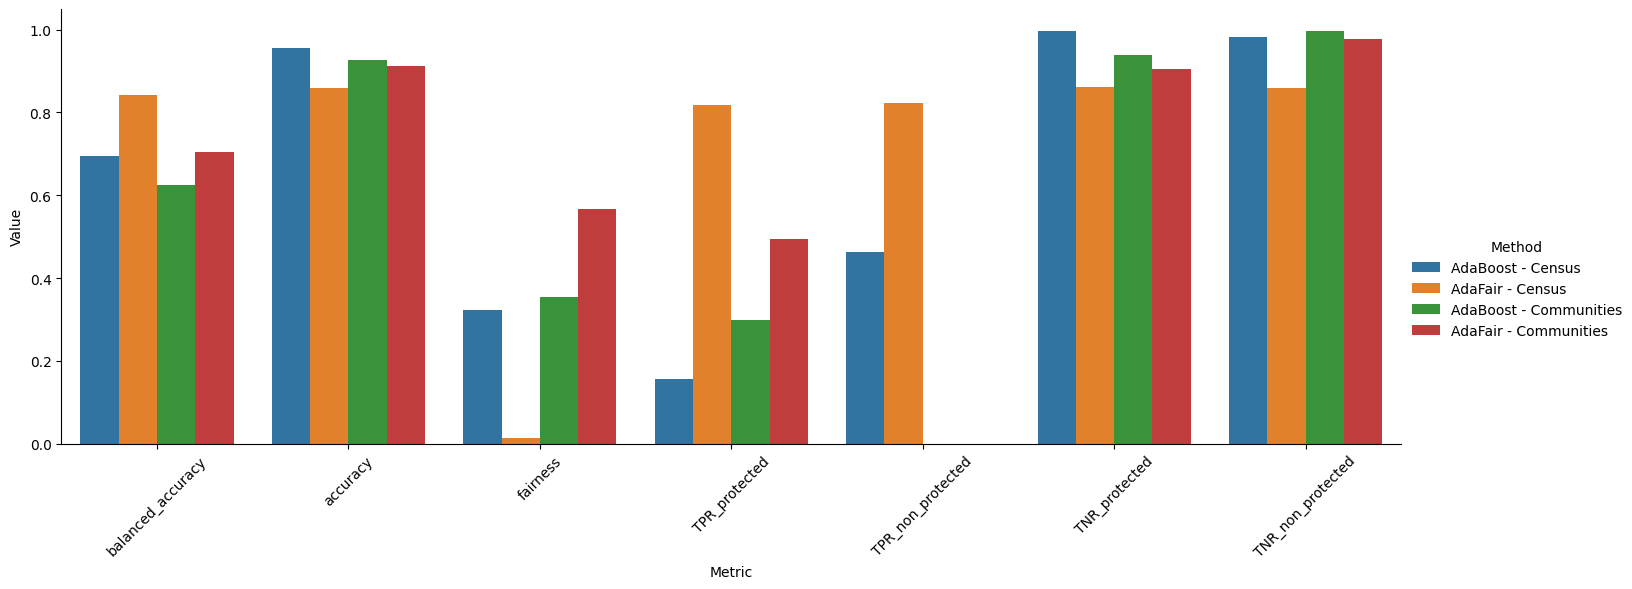

In [30]:
# comparing adaboost and adafair between census and communities dataset

results = {
    'AdaBoost - Census': avg_result_adaboost_census,
    'AdaFair - Census': avg_result_adafair_census,
    'AdaBoost - Communities': avg_results_adaboost_communities,
    'AdaFair - Communities': avg_results_adafair_communities
}

# Convert to long-form DataFrame for sns.catplot
data = []
for method, metrics in results.items():
    for metric, value in metrics.items():
        data.append({'Method': method, 'Metric': metric, 'Value': value})

df = pd.DataFrame(data)

# Plot
g = sns.catplot(
    data=df,
    kind="bar",
    x="Metric",
    y="Value",
    hue="Method",
    height=6,
    aspect=2
)

g.set_xticklabels(rotation=45)
g.set(ylim=(0, 1.05))
plt.tight_layout()
g._legend.set_bbox_to_anchor((1.15, 0.5))  # Moves legend to the right
plt.show()


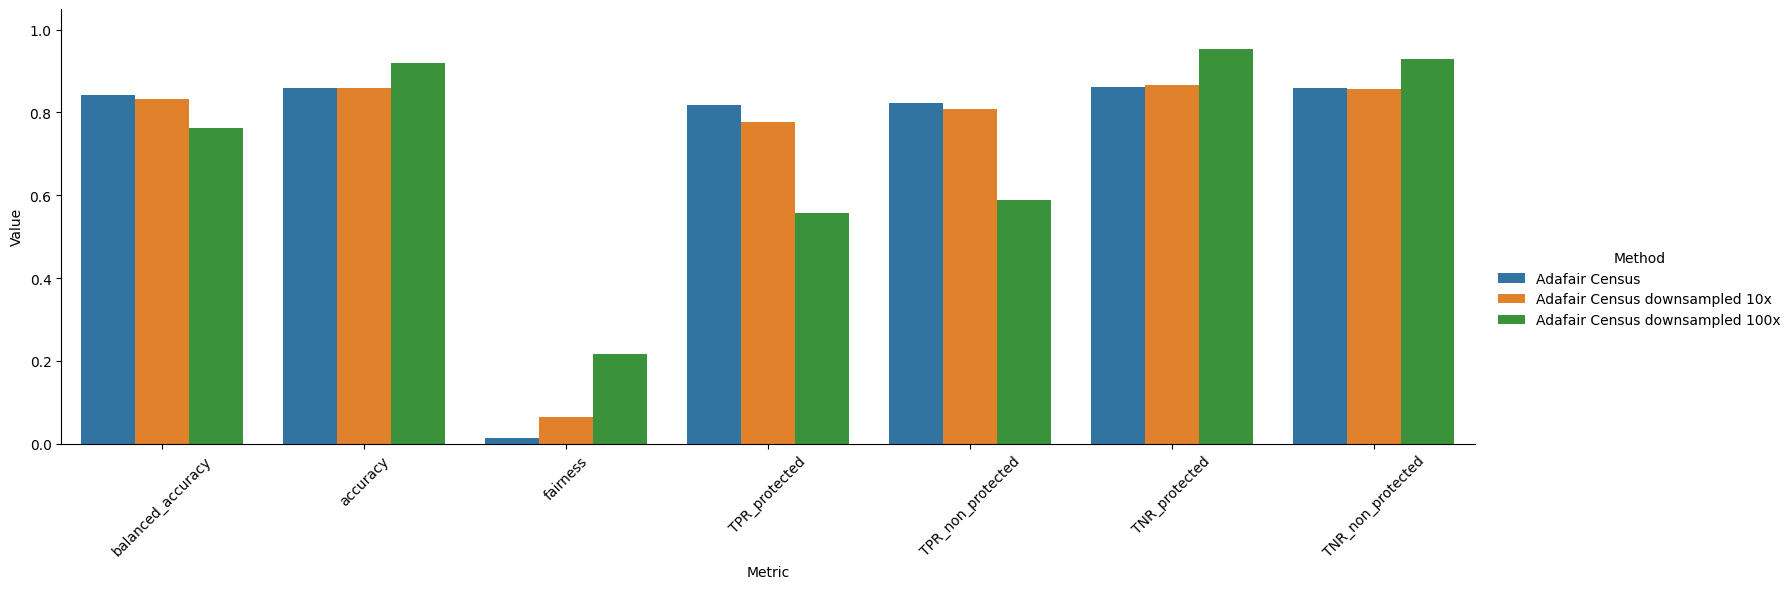

In [31]:
# comparing adafair between census and census downsampled

results = {
    'Adafair Census': avg_result_adafair_census,
    'Adafair Census downsampled 10x': avg_results_adafair_census_downsample_10,
    'Adafair Census downsampled 100x': avg_results_adafair_census_downsample_100,
}

# Convert to long-form DataFrame for sns.catplot
data = []
for method, metrics in results.items():
    for metric, value in metrics.items():
        data.append({'Method': method, 'Metric': metric, 'Value': value})

df = pd.DataFrame(data)

# Plot
g = sns.catplot(
    data=df,
    kind="bar",
    x="Metric",
    y="Value",
    hue="Method",
    height=6,
    aspect=2
)

g.set_xticklabels(rotation=45)
g.set(ylim=(0, 1.05))
plt.tight_layout()
g._legend.set_bbox_to_anchor((1.20, 0.5))  # Moves legend to the right
plt.show()


In [32]:
# compare exact results census vs 100x downsampled
print(avg_result_adafair_census)
print(avg_results_adafair_census_downsample_100)

{'balanced_accuracy': 0.8415417812111736, 'accuracy': 0.8584547767753874, 'fairness': 0.012582933951845532, 'TPR_protected': 0.8170327472181205, 'TPR_non_protected': 0.8238588196765928, 'TNR_protected': 0.8625819794097188, 'TNR_non_protected': 0.8584742852051509}
{'balanced_accuracy': 0.7633434491026938, 'accuracy': 0.9202312138728324, 'fairness': 0.2164456315361857, 'TPR_protected': 0.5577777777777777, 'TPR_non_protected': 0.5897641739980449, 'TNR_protected': 0.95256945649591, 'TNR_non_protected': 0.9282319183779597}


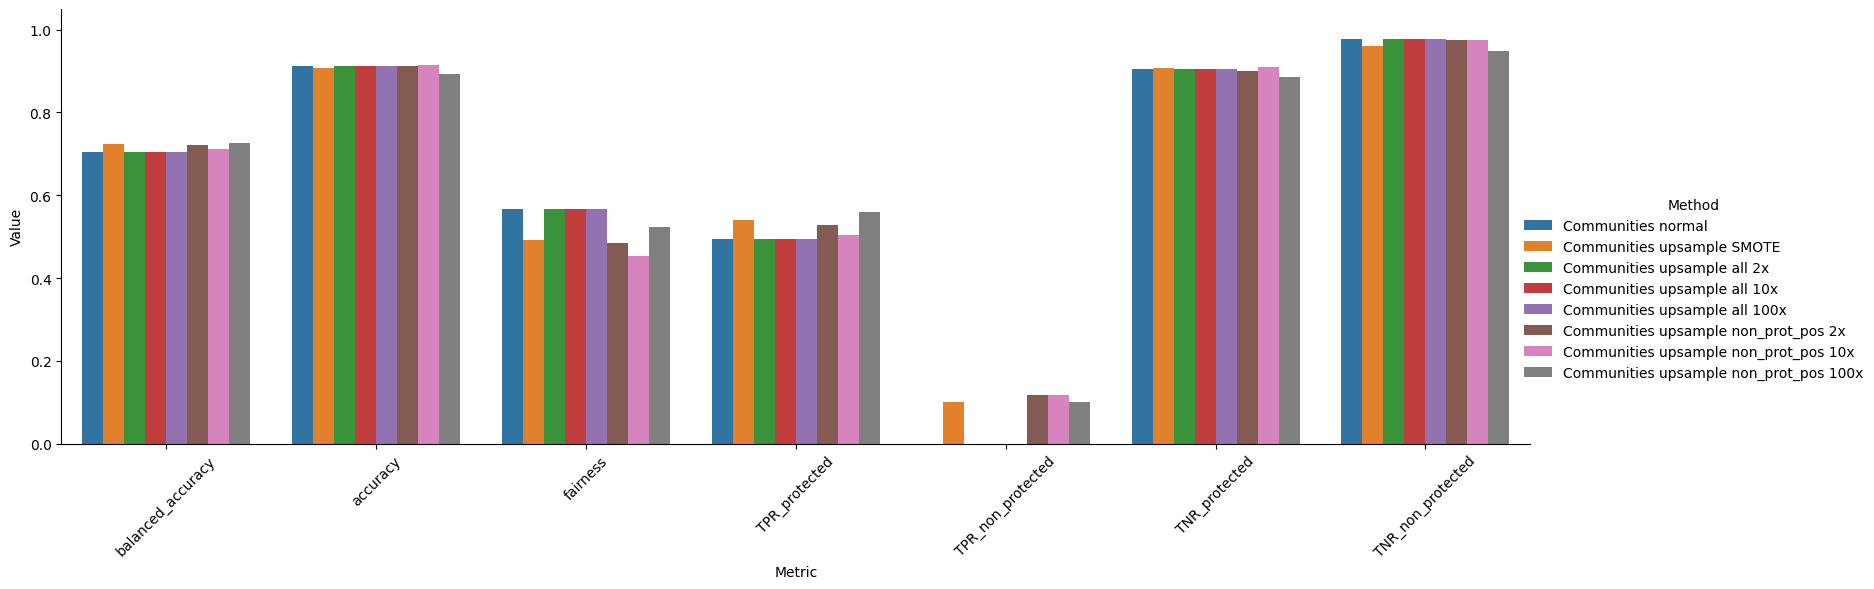

In [33]:
# comparing adafair performance communities normal and upsampled dataset

results = { 'Communities normal': avg_results_adafair_communities,
           'Communities upsample SMOTE': avg_results_adafair_communities_smote,
           'Communities upsample all 2x': avg_results_adafair_communities_upsample_all_2,
           'Communities upsample all 10x': avg_results_adafair_communities_upsample_all_10,
           'Communities upsample all 100x': avg_results_adafair_communities_upsample_all_100,
           'Communities upsample non_prot_pos 2x': avg_results_adafair_communities_upsample_non_prot_pos_2,
           'Communities upsample non_prot_pos 10x': avg_results_adafair_communities_upsample_non_prot_pos_10,
           'Communities upsample non_prot_pos 100x': avg_results_adafair_communities_upsample_non_prot_pos_100,
}

# Convert to long-form DataFrame for sns.catplot
data = []
for method, metrics in results.items():
    for metric, value in metrics.items():
        data.append({'Method': method, 'Metric': metric, 'Value': value})

df = pd.DataFrame(data)

# Plot
g = sns.catplot(
    data=df,
    kind="bar",
    x="Metric",
    y="Value",
    hue="Method",
    height=6,
    aspect=2
)

g.set_xticklabels(rotation=45)
g.set(ylim=(0, 1.05))
plt.tight_layout()
g._legend.set_bbox_to_anchor((1.21, 0.5))  # Moves legend to the right
plt.show()

In [34]:
# average of the upsample non_prot_pos
results_list_non_prot_pos = [avg_results_adafair_communities_upsample_non_prot_pos_2, avg_results_adafair_communities_upsample_non_prot_pos_10, avg_results_adafair_communities_upsample_non_prot_pos_100]

# Convert the list of dictionaries to a DataFrame
df_results_list_non_prot_pos = pd.DataFrame(results_list_non_prot_pos)

# Compute the mean for each metric
results_list_non_prot_pos = df_results_list_non_prot_pos.mean()

# Convert the result to a dictionary for consistency
average_results_adafair_upsample_non_prot_pos_avg = results_list_non_prot_pos.to_dict()

In [35]:
# average of the upsample all

results_list_all = [avg_results_adafair_communities_upsample_all_2, avg_results_adafair_communities_upsample_all_10, avg_results_adafair_communities_upsample_all_100]

# Convert the list of dictionaries to a DataFrame
df_results_list_all = pd.DataFrame(results_list_all)

# Compute the mean for each metric
results_list_all = df_results_list_all.mean()

# Convert the result to a dictionary for consistency
average_results_adafair_upsample_all_avg = results_list_all.to_dict()

In [36]:
# average of the upsample 2x

results_list_2x = [avg_results_adafair_communities_upsample_all_2, avg_results_adafair_communities_upsample_non_prot_pos_2]

# Convert the list of dictionaries to a DataFrame
df_results_list_2x = pd.DataFrame(results_list_2x)

# Compute the mean for each metric
results_list_2x = df_results_list_2x.mean()

# Convert the result to a dictionary for consistency
average_results_adafair_upsample_2x_avg = results_list_2x.to_dict()

In [37]:
# average of the upsample 10x

results_list_10x = [avg_results_adafair_communities_upsample_all_10, avg_results_adafair_communities_upsample_non_prot_pos_10]

# Convert the list of dictionaries to a DataFrame
df_results_list_10x = pd.DataFrame(results_list_10x)

# Compute the mean for each metric
results_list_10x = df_results_list_10x.mean()

# Convert the result to a dictionary for consistency
average_results_adafair_upsample_10x_avg = results_list_10x.to_dict()

In [38]:
# average of the upsample 100x

results_list_100x = [avg_results_adafair_communities_upsample_all_100, avg_results_adafair_communities_upsample_non_prot_pos_100]

# Convert the list of dictionaries to a DataFrame
df_results_list_100x = pd.DataFrame(results_list_100x)

# Compute the mean for each metric
results_list_100x = df_results_list_100x.mean()

# Convert the result to a dictionary for consistency
average_results_adafair_upsample_100x_avg = results_list_100x.to_dict()

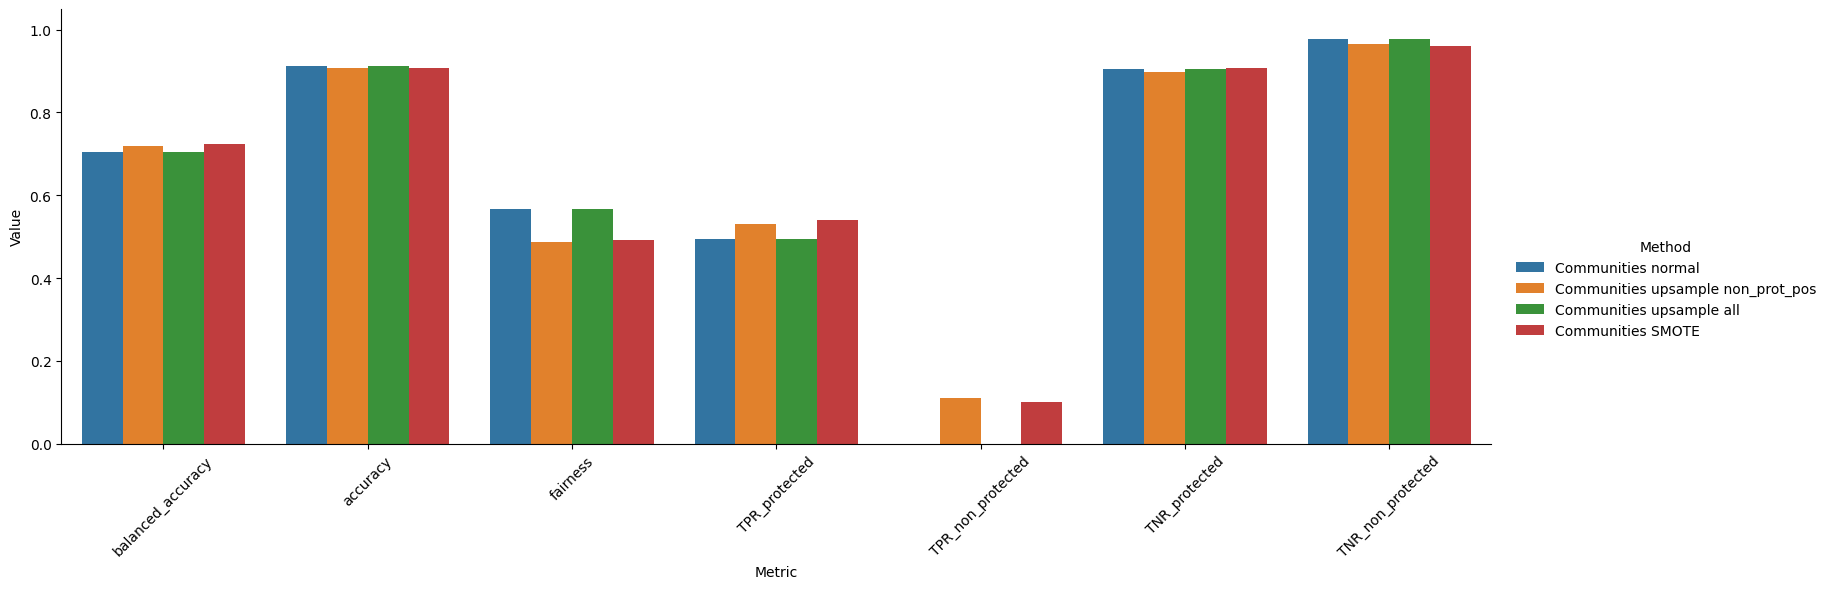

In [39]:
# comparing adafair performance communities normal and upsample type

results = {'Communities normal': avg_results_adafair_communities,
           'Communities upsample non_prot_pos':average_results_adafair_upsample_non_prot_pos_avg,
           'Communities upsample all':average_results_adafair_upsample_all_avg, 
           'Communities SMOTE':avg_results_adafair_communities_smote,            
}

# Convert to long-form DataFrame for sns.catplot
data = []
for method, metrics in results.items():
    for metric, value in metrics.items():
        data.append({'Method': method, 'Metric': metric, 'Value': value})

df = pd.DataFrame(data)

# Plot
g = sns.catplot(
    data=df,
    kind="bar",
    x="Metric",
    y="Value",
    hue="Method",
    height=6,
    aspect=2
)

g.set_xticklabels(rotation=45)
g.set(ylim=(0, 1.05))
plt.tight_layout()
g._legend.set_bbox_to_anchor((1.21, 0.5))  # Moves legend to the right
plt.show()

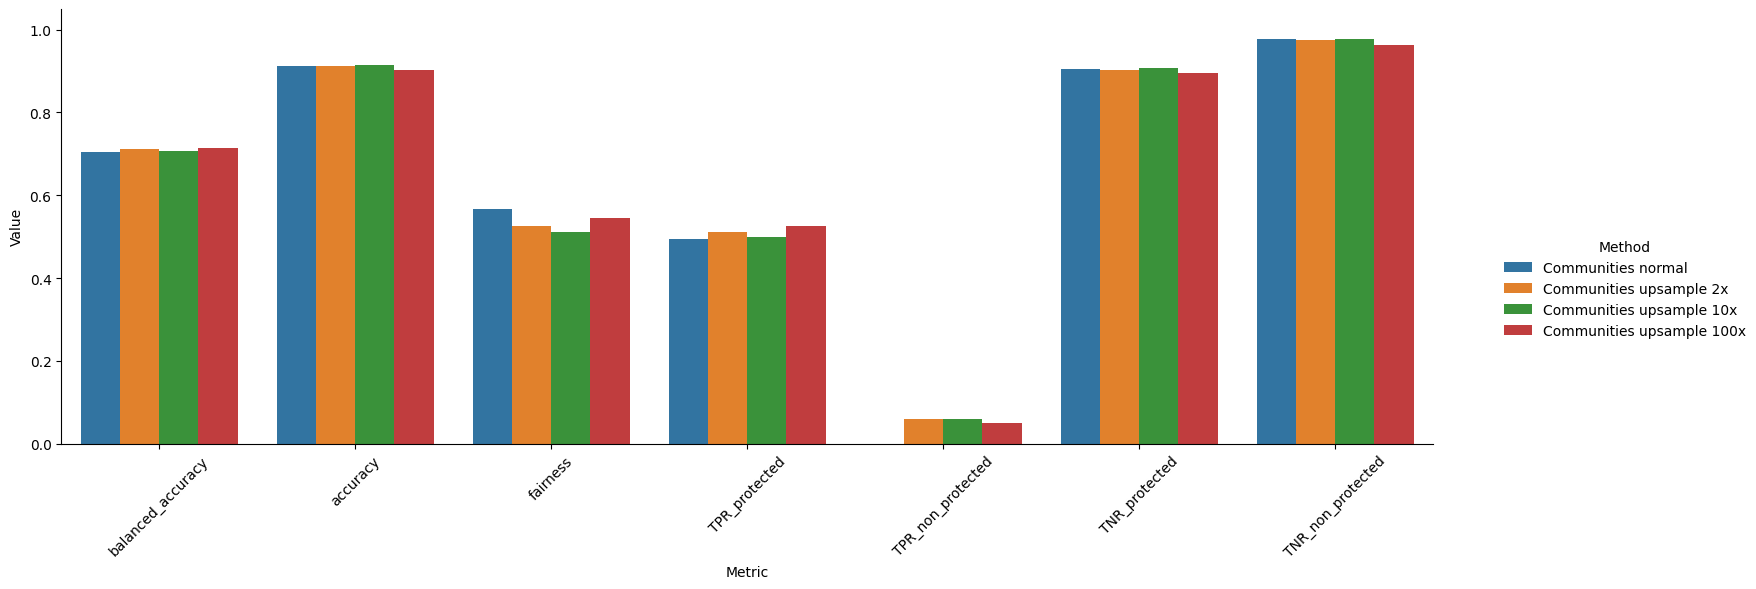

In [40]:
# comparing adafair performance communities normal and upsample rate

results = { 'Communities normal': avg_results_adafair_communities,
           'Communities upsample 2x': average_results_adafair_upsample_2x_avg,
           'Communities upsample 10x': average_results_adafair_upsample_10x_avg,
           'Communities upsample 100x': average_results_adafair_upsample_100x_avg,
}

# Convert to long-form DataFrame for sns.catplot
data = []
for method, metrics in results.items():
    for metric, value in metrics.items():
        data.append({'Method': method, 'Metric': metric, 'Value': value})

df = pd.DataFrame(data)

# Plot
g = sns.catplot(
    data=df,
    kind="bar",
    x="Metric",
    y="Value",
    hue="Method",
    height=6,
    aspect=2
)

g.set_xticklabels(rotation=45)
g.set(ylim=(0, 1.05))
plt.tight_layout()
g._legend.set_bbox_to_anchor((1.21, 0.5))  # Moves legend to the right
plt.show()

plot the distibution of the groups in Communities and Crime dataset

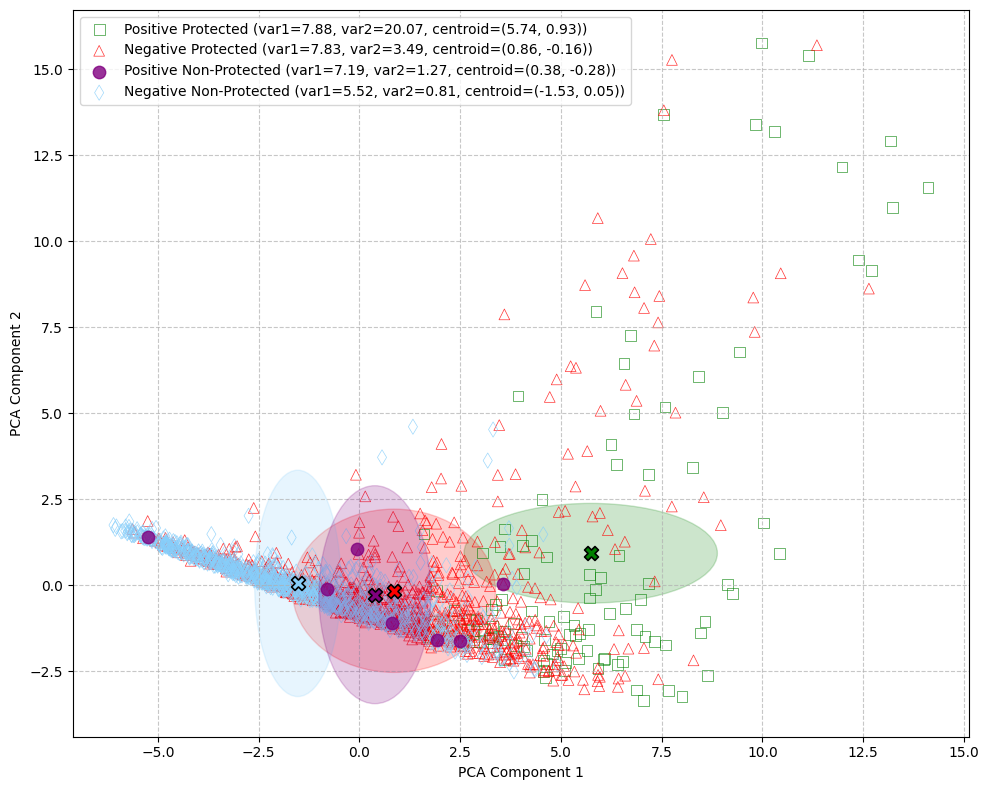

In [41]:
#Prepare data for PCA excluding protected and class attribute
feature_columns = [col for col in df_communities.columns if col not in ['racepctblack', 'class']]
X = df_communities[feature_columns].values
scaler = StandardScaler() # scale to prevent features with high values dominating PCA
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create group labels for all instances
group_labels = np.array([''] * len(df_communities), dtype=object)
group_labels[(df_communities['racepctblack'] == 1) & (df_communities['class'] == 1)] = 'Positive Protected'
group_labels[(df_communities['racepctblack'] == 1) & (df_communities['class'] == -1)] = 'Negative Protected'
group_labels[(df_communities['racepctblack'] == 0) & (df_communities['class'] == 1)] = 'Positive Non-Protected'
group_labels[(df_communities['racepctblack'] == 0) & (df_communities['class'] == -1)] = 'Negative Non-Protected'

# Define colors and markers for each group
group_info = {
    'Positive Protected': {'color': 'green', 'marker': 's'},
    'Negative Protected': {'color': 'red', 'marker': '^'},
    'Positive Non-Protected': {'color': 'purple', 'marker': 'o'},
    'Negative Non-Protected': {'color': 'lightskyblue', 'marker': 'd'}
}

# Function to create a confidence ellipse
def confidence_ellipse(x, y, ax, n_std=2.0, **kwargs):
    if len(x) <= 2:  # Need  Need at least 2 points to calculate covariance
        return
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    # Chi-square value for 95% confidence
    scale = np.sqrt(stats.chi2.ppf(0.95, 2))
    ellipse = Ellipse(
        (np.mean(x), np.mean(y)),
        width=ell_radius_x * 2 * scale,
        height=ell_radius_y * 2 * scale,
        **kwargs
    )
    ax.add_patch(ellipse)
    return ellipse

# Create scatter plot
plt.figure(figsize=(10, 8))
for group, info in group_info.items():
    mask = group_labels == group
    if np.sum(mask) > 0:  # Only plot if the group has instances
        # Compute variances along PCA Component 1 and 2
        var_pc1 = np.var(X_pca[mask, 0])
        var_pc2 = np.var(X_pca[mask, 1])
        # compute the centroid 
        x_centroid = np.mean(X_pca[mask, 0])
        y_centroid = np.mean(X_pca[mask, 1])
        label = f"{group} (var1={var_pc1:.2f}, var2={var_pc2:.2f}, centroid=({x_centroid:.2f}, {y_centroid:.2f}))"
        z = 10 if group == 'Positive Non-Protected' else 1 # make sure Positive Non-Protected is put on the forefront

        # making only Positive Non-Protected filled in
        if group == 'Positive Non-Protected':
            plt.scatter(
                X_pca[mask, 0], X_pca[mask, 1],
                color=info['color'], marker=info['marker'],
                label=label, alpha=0.8, s=80, zorder=z
            )
        else:
            plt.scatter(
                X_pca[mask, 0], X_pca[mask, 1],
                facecolors='none', edgecolors=info['color'], marker=info['marker'],
                label=label, alpha=0.8, s=60, linewidths=0.5, zorder=z
            )

        # Add ellipse
        confidence_ellipse(
            X_pca[mask, 0], X_pca[mask, 1],
            plt.gca(),
            n_std=2.0,
            facecolor=info['color'], edgecolor=info['color'],
            alpha=0.2, zorder=z - 1
        )
        
        # Plot the centroid in group color with a black edge
        plt.scatter(
            x_centroid, y_centroid,
            marker='X', s=100,
            c=info['color'], edgecolors='black', linewidths=1.2,
            zorder=20
        )



# Customize the plot
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('point_cloud_communities_with_ellipses.png')
plt.show()